# Determining Feature Importances

This notebook is for exploring feature importance within a black box LSTM. I'll be starting with Permuation Importances and Shapley values.

### Building the Dataset

In [1]:
%cd ..
%cd .. 
%cd data

/Users/azel/github/Data-Science/jupyter_notebooks
/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/data


In [47]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib.pyplot as plt

from shap import DeepExplainer, summary_plot

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%cd ..
%cd jupyter_notebooks/exploratory_modeling

/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/jupyter_notebooks/exploratory_modeling


In [4]:
def tech_company_data(ticker):
    """
    Containes Tech Index
    """    
    dts = DailyTimeSeries(ticker)
    df = dts.initiate()
    with HiddenPrints():
        df = dts.add_securities(['XLK', 'vix', 'SPX'], primary_df=df)
        df = dts.add_technicals(['SMA', 'EMA', 'MACD', 'STOCH', 
                                   'RSI', 'ADX', 'CCI', 'BBANDS', 
                                   'AD', 'OBV'], 
                                  primary_df=df)
        df = dts.add_macro(primary_df=df, 
                             indices=['trade_index', 'longterm_rates'])
    
    return df

In [5]:
df = tech_company_data('AAPL')

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-10 11:52:43 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


In [6]:
def get_target(df, target, time_shift=1):
    """
    Selects a target by shifting a specific column 
    by one timestep. Then seperates the training data 
    and target into X and y respectively. 
    
    ###############
    Parameters:
    ###############
    
    df: Timeseries dataframe created by fin_data
    target: percent_move or existing feature shifted by 
            timeshift.
    timeshift: number of timesteps to shift the feature by.
    
    """
    if target == 'percent_move':

        df['target'] = ((df['AAPL_adjusted_close'].shift(-1) -
                         df['AAPL_adjusted_close']) / 
                        (df['AAPL_adjusted_close']))*100
    
    elif target == 'abs_percent_move':
        
        df['target'] = np.abs(((df['AAPL_adjusted_close'].shift(-1) -
                                df['AAPL_adjusted_close']) / 
                               (df['AAPL_adjusted_close']))*100)

    else:

        df['target'] = df[target].shift(-time_shift)
        
    df = df.dropna()
    
    X = df.drop(columns='target').values
    y = df[['target']].values
    
    return X, y

In [7]:
X, y = get_target(df, 'AAPL_adjusted_close')

In [8]:
def prep_data(train_cut, val_cut, X=X, y=y):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [9]:
def extract_data(generator):
    for i in np.arange(len(generator)):
        if i == 0:
            a, b = generator[i]
        else: 
            c, d = generator[i]

            a = np.vstack((a, c))
            b = np.vstack((b, d))
            
    return a, b

In [10]:
X_train, X_test, X_val, y_train, y_test, y_val = prep_data(train_cut=.8,
                                                           val_cut=.6)

In [11]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=1)

test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=1)

val_data_generator = TimeseriesGenerator(X_val, y_val, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=1)

In [12]:
X_val_mod, y_val_mod = extract_data(val_data_generator)

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights/{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history = model.fit_generator(train_data_generator, 
                              epochs = 50,
                              validation_data=test_data_generator,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/50
3941/3941 [==============================] - 108s 27ms/step - loss: 280.2372 - val_loss: 1625.6575

Epoch 00001: val_loss improved from inf to 1625.65749, saving model to weights/01-1625.66.hdf5
Epoch 2/50
3941/3941 [==============================] - 106s 27ms/step - loss: 188.3517 - val_loss: 886.3205

Epoch 00002: val_loss improved from 1625.65749 to 886.32054, saving model to weights/02-886.32.hdf5
Epoch 3/50
3941/3941 [==============================] - 106s 27ms/step - loss: 101.5469 - val_loss: 639.1313

Epoch 00003: val_loss improved from 886.32054 to 639.13130, saving model to weights/03-639.13.hdf5
Epoch 4/50
3941/3941 [==============================] - 106s 27ms/step - loss: 87.0222 - val_loss: 782.1334

Epoch 00004: val_loss did not improve from 639.13130
Epoch 5/50
3941/3941 [==============================] - 106s 27ms/step - loss: 69.0566 - val_loss: 961.6872

Epoch 00005: val_loss did not improve from 639.13130
Epoch 6/50
3941/3941 [=============================

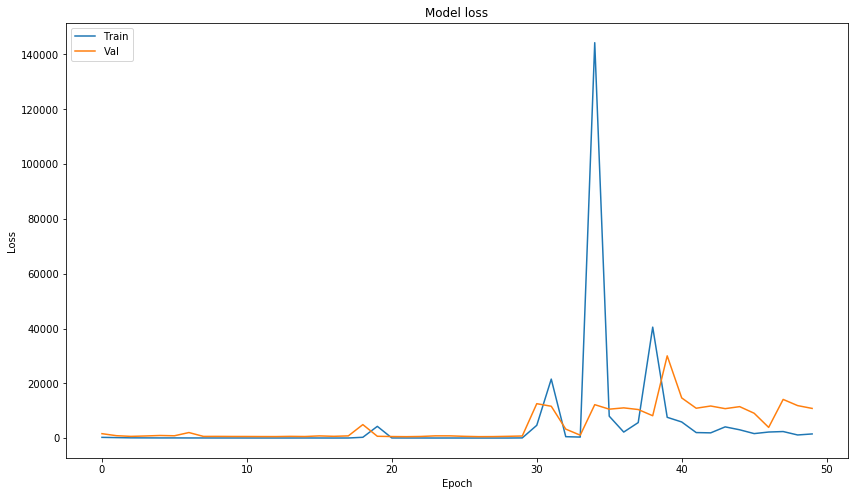

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

The model as it stands is relatively inconsistent. This is an example of a pretty bad run. Instead of keeping these weights, I am going to load the weights of a better performing model.

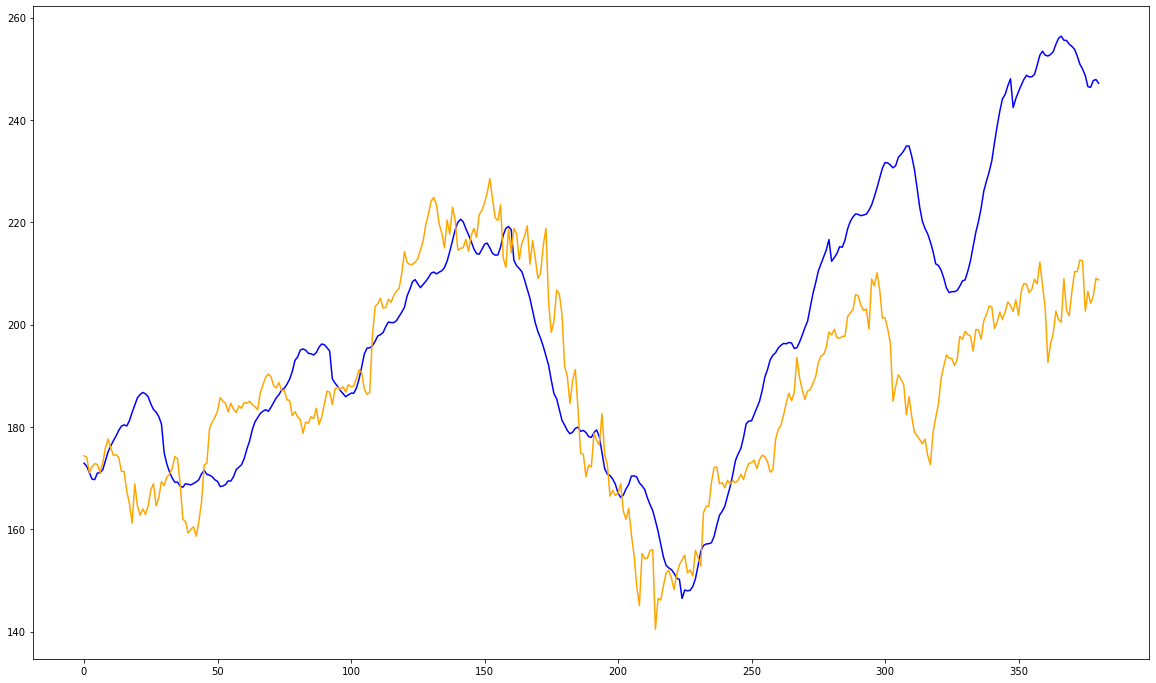

In [24]:
list_of_files = glob.glob('weights/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

model.load_weights(latest_file)

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(val_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred, color='blue')
plt.plot(y_val_mod, color='orange');

### Shap

In [25]:
de = DeepExplainer(model = model, data=X_val_mod)

In [26]:
shaps_vals = de.shap_values(X_val_mod)

The resulting Shapley values are still in the same shape as the input data. That is, each individual data point within each individual sampling of time steps is converted to shapley values. That is useful for looking at the data sample by sample. However, if we want to look at the data from a macro point of view we need to convert the shape of the array to something 2-dimensional. 

I do this by finding the mean shapley value of each feature in each sample. This will decrease the micro-interpretability in exchange for macro-interpretability. 

In [27]:
print(shaps_vals[0].shape)
print(shaps_vals[0][0].shape)
print(shaps_vals[0][0][0].shape)

(381, 15, 49)
(15, 49)
(49,)


In [69]:
shaps_vals[0][0][0]

array([ 1.53832345e-01, -5.97936566e-02,  1.28903607e-01,  2.67760354e-01,
       -7.67730731e-01, -1.00436930e-01, -1.49550776e-02, -9.29377433e-02,
       -9.57901073e-04, -3.27751309e-01, -2.90167992e-01, -4.17804249e-01,
        4.38532524e-01, -6.01723969e-02,  0.00000000e+00, -4.89647906e-02,
       -1.09722375e-02,  2.72735672e-02, -1.61639793e-02,  5.46926371e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.35344022e-02,
        3.32940340e-02, -3.15197212e-02, -7.16266659e-02, -8.13416120e-02,
        3.20291384e-02,  0.00000000e+00,  0.00000000e+00, -2.95083060e-02,
        2.88777566e-02, -2.45381376e-03,  3.44089331e-02, -7.83364393e-02,
        1.20358520e+00,  5.09090806e-02, -1.32489061e+00,  1.96078664e-01,
       -3.28456461e-01, -2.78248831e-02,  1.05813374e-01, -2.25716700e-02,
       -3.85497643e-03, -1.38642767e-02, -2.09584852e-01, -1.53457464e-01,
       -8.83423782e-02])

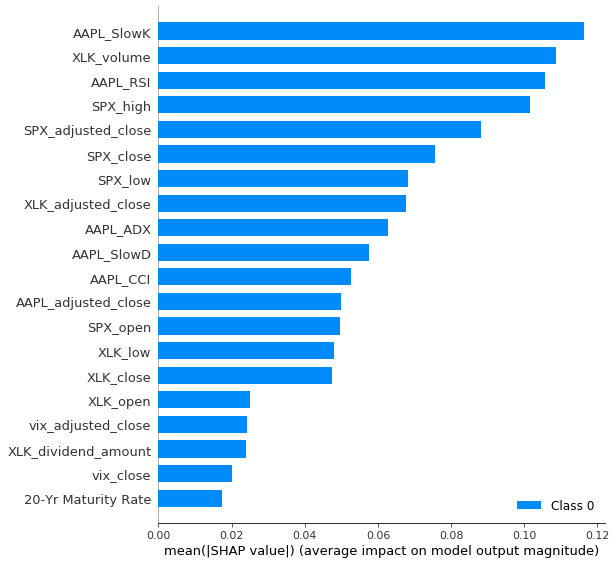

In [64]:
summary_plot([shaps_vals[0][100]], feature_names=df.columns)

In [29]:
def individual_array(sample):
    
    # get the means for each sampling
    for i in np.arange(len(sample[0])):
        means = []
        for j in np.arange(len (sample)):
            means.append(sample[j][i])
        s_value = np.array(np.mean(means))

        if i == 0:
            final_array = s_value
        else:
            final_array = np.hstack((final_array, s_value))
            
    return final_array


In [72]:
individual_array(shaps_vals[0][0])

array([ 0.07143448, -0.03180153,  0.06149313,  0.12175029, -0.31118794,
       -0.02161095,  0.05615494, -0.10141305, -0.0332586 , -0.19895259,
       -0.16839079, -0.2471737 ,  0.34342665, -0.0223442 ,  0.        ,
        0.01164287, -0.12146599, -0.00561293, -0.10813102,  0.23025823,
        0.        ,  0.        ,  0.        , -0.08837795, -0.14674572,
       -0.15469426, -0.14223638, -0.16668262,  0.0302153 ,  0.        ,
        0.        , -0.01220908,  0.01256514,  0.00946776,  0.01195665,
       -0.04535404,  0.23342266, -0.03578681, -0.38880962,  0.02746799,
       -0.08529452, -0.01710611,  0.04750914, -0.01206174, -0.00539799,
       -0.00714223, -0.10548058, -0.09215553, -0.05764264])

In [76]:
flatten_shap_values(shaps_vals).shape

(381, 49)

In [30]:
def flatten_shap_values(shap_vals):
    
    #Pull the array out of the list. 
    sv = shap_vals[0]
    
    count = 0
    for sample in sv: 
        sample_array = individual_array(sample)
        if count == 0:
            final_array = sample_array
        else:
            final_array = np.vstack((final_array, sample_array))
        
        count +=1
        
    return final_array
    

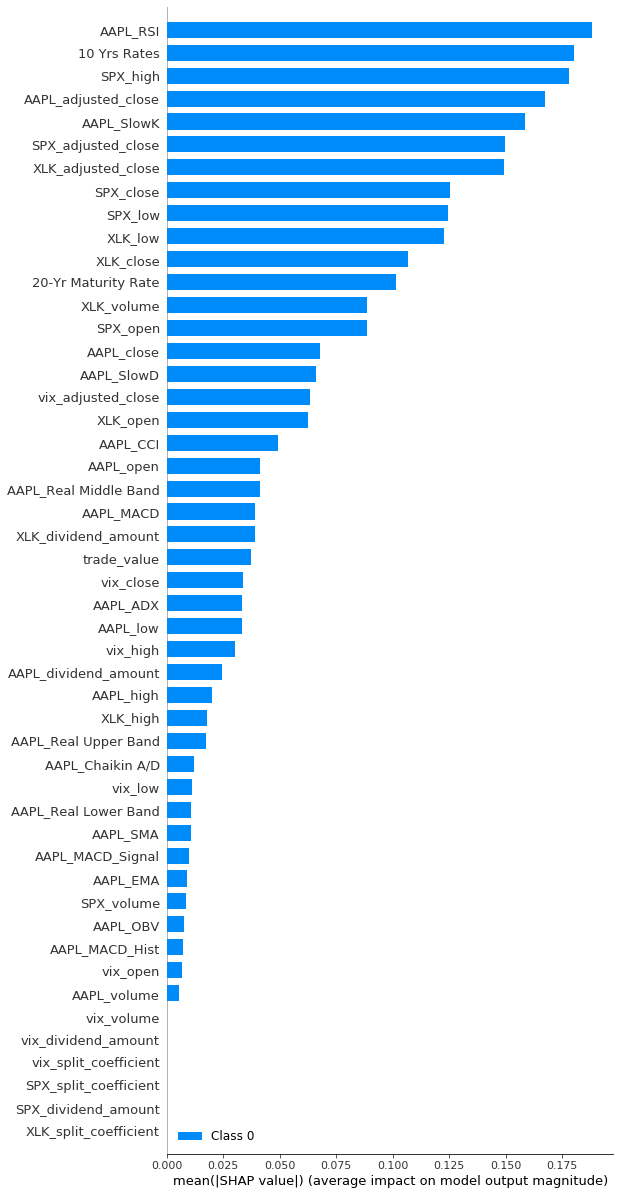

In [102]:
summary_plot([flatten_shap_values(shaps_vals)], 
             feature_names=(df.drop(columns='target')
                            .columns
                            .tolist()), 
             max_display=49)

In [91]:
shap_df = pd.DataFrame(data=flatten_shap_values(shaps_vals),columns = df.drop(columns='target').columns.tolist())

In [93]:
shap_df.describe()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,AAPL_SMA,AAPL_EMA,AAPL_MACD_Signal,AAPL_MACD_Hist,AAPL_MACD,AAPL_SlowK,AAPL_SlowD,AAPL_RSI,AAPL_ADX,AAPL_CCI,AAPL_Real Upper Band,AAPL_Real Middle Band,AAPL_Real Lower Band,AAPL_Chaikin A/D,AAPL_OBV,trade_value,10 Yrs Rates,20-Yr Maturity Rate
count,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,381.0,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,381.0,381.0,381.0,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,381.0,381.0,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02,3.810000e+02
mean,-1.021167e-09,2.924961e-10,-2.591854e-10,-1.147963e-09,-8.337822e-10,-1.078251e-11,4.303507e-09,3.046367e-09,4.202546e-09,-8.818775e-11,7.451577e-09,-1.606070e-09,-6.112810e-09,-5.146692e-09,0.0,1.400416e-09,-1.977548e-09,8.074022e-09,2.298763e-09,-2.850537e-09,0.0,0.0,0.0,3.854619e-09,7.388217e-09,3.304255e-09,1.392984e-09,6.397091e-09,-8.226765e-10,0.0,0.0,5.454758e-10,-4.983756e-10,5.027120e-10,4.490932e-10,3.011313e-09,-1.028934e-09,1.779111e-08,6.285575e-09,2.430996e-11,4.608849e-09,5.780349e-10,-1.472735e-09,-1.246400e-09,5.616338e-10,3.768184e-10,-4.396184e-09,-2.745496e-08,-1.164395e-08
std,4.975235e-02,2.403887e-02,3.991294e-02,8.125282e-02,1.984764e-01,6.512786e-03,3.085594e-02,7.598255e-02,2.202039e-02,1.487413e-01,1.293948e-01,1.815865e-01,1.190525e-01,6.086126e-02,0.0,9.707110e-03,3.647227e-02,1.334339e-02,4.007873e-02,7.707187e-02,0.0,0.0,0.0,1.077088e-01,2.149672e-01,1.508255e-01,1.522531e-01,1.810378e-01,1.087962e-02,0.0,0.0,1.270508e-02,1.057085e-02,1.226898e-02,9.126988e-03,4.909381e-02,1.874625e-01,7.847620e-02,2.295420e-01,3.879540e-02,5.602022e-02,2.041835e-02,4.981909e-02,1.279028e-02,1.447626e-02,9.172534e-03,4.458002e-02,2.526278e-01,1.392362e-01
min,-1.000714e-01,-4.311588e-02,-7.887325e-02,-1.598835e-01,-3.824350e-01,-2.161095e-02,-1.871105e-02,-1.592956e-01,-5.277731e-02,-3.048285e-01,-2.535441e-01,-3.313732e-01,-1.990075e-01,-2.936522e-02,0.0,-2.114774e-02,-1.389288e-01,-4.874917e-02,-1.195389e-01,-1.022552e-01,0.0,0.0,0.0,-2.818406e-01,-5.310464e-01,-3.926012e-01,-3.962712e-01,-4.632902e-01,-2.466134e-02,0.0,0.0,-2.402800e-02,-2.048822e-02,-1.603245e-02,-2.181851e-02,-1.222107e-01,-3.534967e-01,-1.824141e-01,-4.237776e-01,-9.105245e-02,-1.227396e-01,-4.144345e-02,-9.584865e-02,-2.240753e-02,-3.396030e-02,-1.874607e-02,-1.054806e-01,-3.903725e-01,-2.038990e-01
25%,-3.738056e-02,-2.019278e-02,-3.225024e-02,-6.359682e-02,-1.668617e-01,-4.228182e-03,-1.619866e-02,-5.833569e-02,-1.495843e-02,-1.175418e-01,-1.042519e-01,-1.497462e-01,-7.946829e-02,-2.526763e-02,0.0,-5.631890e-03,-2.702836e-02,-1.006363e-02,-3.143725e-02,-6.573027e-02,0.0,0.0,0.0,-7.408004e-02,-1.416901e-01,-1.092622e-01,-1.056962e-01,-1.255587e-01,-7.482578e-03,0.0,0.0,-1.055398e-02,-7.994909e-03,-8.651276e-03,-4.846443e-03,-2.264931e-02,-1.446905e-01,-6.146989e-02,-1.628934e-01,-3.019558e-02,-5.372305e-02,-1.801439e-02,-3.742666e-02,-8.509752e-03,-1.017711e-02,-7.292033e-03,-1.718624e-02,-1.327064e-01,-7.795687e-02
50%,4.293571e-03,-3.184353e-03,2.560489e-03,6.084618e-03,-1.893632e-02,4.530393e-04,-1.562590e-02,-7.619921e-03,-1.335229e-03,-1.460672e-02,-1.650630e-02,-1.720790e-02,-2.522420e-02,-2.352527e-02,0.0,-1.243897e-03,1.021977e-02,2.114753e-03,9.285643e-03,-1.767350e-02,0.0,0.0,0.0,-1.0

In [126]:
shap_df.describe().T[['mean']]

,mean
AAPL_open,-1.021167e-09
AAPL_high,2.924961e-10
AAPL_low,-2.591854e-10
AAPL_close,-1.147963e-09
AAPL_adjusted_close,-8.337822e-10
AAPL_volume,-1.078251e-11
AAPL_dividend_amount,4.303507e-09
XLK_open,3.046367e-09
XLK_high,4.202546e-09
XLK_low,-8.818775e-11


Thus we have the macro interpretation. It is recommended that we look at both the micro and macro interpretability to better understand feature interaction in the model. 